# Solver for the Maxwell-bloch equations w/ phase modulation (modulation swipe).

***

## Equations:

Maxwell-bloch equation, after aproximations, with external phase modulation for $E_y$

$
\begin{cases}
\partial_{\tau} E_x=-k E_x + \mu P_x \\
\partial_{\tau} E_y=-k E_y + \mu P_y + i.(\Delta \phi_0 + m.cos(w_{mod}.\tau)).E_x \\
\partial_{\tau} P_{x,y}=-(1+i\delta)P_{x,y}+E_{x,y}.D \\
\partial_{\tau} D=-\gamma_{||}(D-D_0+\tfrac{1}{2}(E^*_{x,y}P_{x,y}+E_{x,y}P^*_{x,y})) \\
\end{cases}
$


with $ E_{x,y}$ and $P_{x,y}$  $\in \mathbb{C}$

##### Normalizations made: 
$\tau= \gamma_{\bot}.t$, $k=\tfrac{\bar{k}}{\gamma_{\bot}}$,  $\gamma_{\parallel}=\tfrac{\bar{\gamma_{\parallel}}}{\gamma_{\bot}}$, $\eta=\tfrac{z}{L}$, $\delta'_{ac}=\tfrac{w_a-w_0}{\gamma_{\bot}}$


##### Aproximations: 

1-$k,\gamma_{\parallel}<<\gamma_{\bot}$   -- Homogenously broadened laser linewidth $ \nabla^2 E-\frac{1}{c^2}\partial_{t^2}E=\alpha \partial_{t^2}E$

2-Plane wave: $\nabla^2_{\bot}=0$

3-Two level medium

4-Slowly varying amplitud

5-Unidirectional field

6-Rotating wave approx $\partial_{t^2}<<\partial_t$

7-Single longitudinal mode

8-$g'->0$, $R_0->1$  -- Uniform field limit

9-$m$,$w_{mod}<<1$, $w_{mod}<<\gamma_{\bot}$  ..chequear..

In [27]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 24 17:05:30 2015

@author: Alexis
"""
import numpy as np
#import scipy as sc
#import matplotlib
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
#from numpy import linspace
#import math
#from matplotlib.collections import LineCollection
from comparefase import comparembfase
from intmbfase import intmbfase as int
#import datetime as dt
from time import localtime
#import time, sys
#import mpld3
from scipy.signal import argrelextrema
from numba import autojit

%matplotlib inline


'''---- |2>
    ||
    || R21
    ||
   ---- |1>'''

plt.ion()
pi=np.pi #defino pi


### Parameters

In [39]:
'''parameters for normalization'''
a=2
gperp=10**8. #gamma perpendicular, loss rate
scale=1*(10.**6)/gperp #scale to micro seconds
wscale=1000*gperp/(10.**6)#scale frequency to khz

In [40]:
'''parameters for the equation'''
k=0.9*10.**7/gperp #normalized loss rate
mu=.25*10**(-4) #g
Dphi0=0.0 #phase shift [-pi,pi]
d=1.0 #detuning
g=2.5*10.**4/gperp #*((2*pi)**2) #sigma parallel, normalized loss rate
D0=a*k/mu #Poblation
wf=0.00474342

'''parameters to compare with the results'''
w_res=np.sqrt(k*g*((D0*mu/k)-1.))*wscale #resonance frequency
a=D0*mu/k
w=np.sqrt(k*g*(a-1.)-(g*g*a*a)/4)*wscale #Relaxation oscilations frequency


swiping parameter: m


In [56]:
mmin=0.02
mmax=0.023
mn=np.arange(mmin, mmax+(mmax-mmin)/2. , (mmax-mmin)/2.) #10 pasos entre la resonancia y 0.1*resonancia
print mn[1]-mn[0]


0.0015


mmin=0.04
mmax=0.05
mn=np.arange(0., 1+(1)/60. , 1/60.) #n evenly paced steps between 0 and 1.
steep=1.
plt.plot(mn,np.arctan(steep*mn),'.b')
mn=np.arctan(steep*mn) #non linear distribution of parameter
mn=((mmax-mmin)/(pi/2)*mn+mmin) #normalize to the min  and max values i want to use
fig=plt.figure()
plt.plot(mn,np.zeros_like(mn),'.b')
plt.xlabel('m')


## Initial conditions, Integration and variables

In [57]:
#Function for initializing simulations after the transition
def  initial(init):
    intime=500.*20*10**(-6)*gperp #integration time FOR TRANDITORY
    if init=='new':
        '''User defined initial condition'''
        timeinit = np.arange(0., intime, 1.)
        dfxinit=[1., 1.] 
        dfyinit=[1.,  -1.9]  
        drxinit=[1.,   1.]
        dryinit=[1.,  -1.9] 
        ddeltainit=[6.65973518e+03]
        yinit=np.array(dfxinit+dfyinit+drxinit+dryinit+ddeltainit)
    if init=='l':
        '''initial condition from last simulation'''
        timeinit = np.arange(time[-1] ,intime*6/20+time[-1] , 1.)
        yinit=y[-1]
    return yinit, timeinit
    


1
[-0.089974999999999999, -0.089974999999999999, -0.051975, 0.19095249999999997, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[6.1439054647921732e-06, -7.2764205590257719e-06, -0.024424910803864879, 0.015685427839531078, -0.0019332866915183766, -0.046146994352669335, -34.950657209838027, 138.69678349207697, -0.035426575855983689]
2
[-0.089974999999999999, -0.089974999999999999, -0.049125000000000002, 0.19245249999999997, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[1.7306146332011456e-06, 1.1454491855647826e-06, 0.020351926340387197, -0.0065620158622407086, 0.010017619620921583, -0.0015918134583850496, 51.516275752227102, -93.039056416191215, 0.034701643867847506]
3
[-0.089974999999999999, -0.089974999999999999, -0.046275000000000011, 0.19395249999999997, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[1.3444101199360792e-07, 7.88500635205153

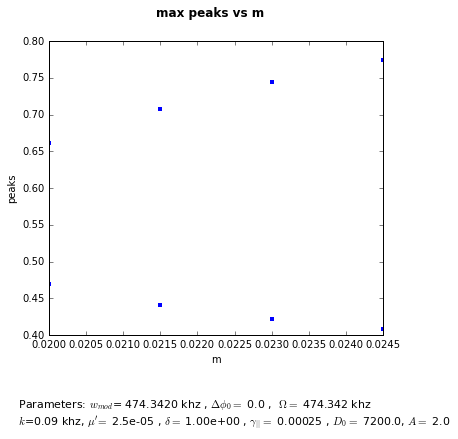

In [63]:
steps=2#number of iterations
peaks=[[0], [0]]
count=0
for m in mn:  #loop for frequencys
    wf_real=wf*wscale
    count=count+1
    print count
    for i in range(steps): #for each freq, integrete some time, and then integrate again using the last result as initial condition
        '''initial conditions'''
        if i==0:
            yinit, time=initial('new')
        if i==1:
            yinit, time=initial('l')
        '''integration'''
        y, time=int(yinit,time,k,mu,Dphi0,d,g,D0,m,wf)
    '''intensitys'''
    intensity_ex=np.sqrt(y[:,0]**2+y[:,1]**2)
    intensity_ey=np.sqrt(y[:,2]**2+y[:,3]**2)
    intensity=np.sqrt(y[:,0]**2+y[:,1]**2+y[:,2]**2+y[:,3]**2)
    '''peaks'''
#    peak_coor=argrelextrema(intensity, np.greater)#find peaks index
    peak_max=list(set(intensity[argrelextrema(intensity, np.greater)[0]]))#intensity peaks
    m_peaks=list(m*np.ones_like(peak_max))#vector or m, the same lenght as peak_max
    peaks[0]=peaks[0]+m_peaks
    peaks[1]=peaks[1]+peak_max
    
'''plots'''
save=True #set True if i want to save files automatically
       
fig_bif=plt.figure()
fig_bif.suptitle('max peaks vs m', fontsize=12, fontweight='bold')
ax2 = fig_bif.add_subplot(111)
ax2.plot(peaks[0][1:],peaks[1][1:],'.b')
ax2.set_xlabel('m')
ax2.set_ylabel('peaks')
plt.text(-0.1,-.32, "\n Parameters: $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.3f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig_bif.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-max_vs_m.png' % localtime()[0:6]
    fig_bif.savefig(fname, dpi = 300)# when saving, specify the DPI

1

[-0.089974999999999999, -0.089974999999999999, -0.051975, 0.19095249999999997, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[-0.00048083057284760048, 0.00038579983193137712, -0.0057783708526014657, -0.0066162198746513162, -0.40151273063888127, 2.738256363585414, -19.432657138734157, 2.5640423557732106, 0.26066365083952392]
2

[-0.089974999999999999, -0.089974999999999999, -0.049125000000000002, 0.19245249999999997, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[-0.00048083057284760048, 0.00038579983193137712, -0.0056671471160846844, -0.0064189619451705199, -0.40151273063888127, 2.738256363585414, -19.432657138734157, 2.5640423557732106, 0.26066365083952392]
3

[-0.089974999999999999, -0.089974999999999999, -0.046275000000000011, 0.19395249999999997, 6659.7351799999997, 6657.7351799999997, 6656.83518, -12652.596841999999, 0.13341370499999985]
[-0.00048083057284760048, 0.000385799831931377

import simplejson
>>> f = open('peaks.txt', 'w')
>>> simplejson.dump(peaks, f)
>>> f.close()

In [61]:
'''plots'''
save=True #set True if i want to save files automatically

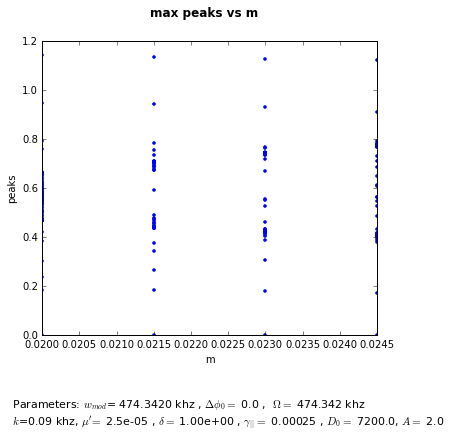

In [36]:
#fig5=plt.figure()
#ax1 = fig5.add_subplot(111)
#f1=plt.plot(time,y[:,0])
#f1=plt.plot(time,y[:,2])
#fig5.suptitle('E_x  & E_y vs tiempo', fontsize=12, fontweight='bold')
#ax1.set_xlabel('time(ms) ')
#ax1.set_ylabel('E ')
#plt.xlim(min(time), max(time))
#plt.text(-0.1,-1.04, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
#plt.subplots_adjust(bottom=0.22)
#fig1.savefig('moduloE_fasemodulada.png')


In [37]:
'''comparison between the solution with and without modulation'''
def comp():
    comparembfase(y,yinit,time,k,mu,Dphi0,d,g,D0,m,wf)

#comp()

Notebook style:

In [38]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())